# Fake & Real news prediction

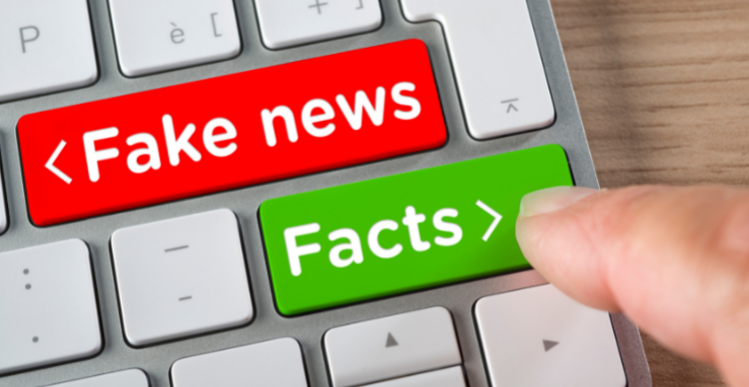

The objective of this exercise is to develop a machine learning program to identify when a news article might be fake.

**Data Description**

The data is given in two csv files - fake and true containing fake and true news respectively.

**fake.csv:** 
* Title: Title of news article
* Text: Body of news article
* Subject: News subject/area
* Date: Date published
 
**true.csv** contains the same fields for real news.

# Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import string, re
import requests
from string import punctuation
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [ ]:
# Load data

fake = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
real = pd.read_csv('../input/fake-and-real-news-dataset/True.csv')

# Exploratory Data Analysis

In [ ]:
fake.head()

In [ ]:
real.head()

In [ ]:
print(fake.info())
print('='*25)
print(real.info())

There are no NaN values in either fake or real datasets

Label fake and true news and concatenate the tables

In [ ]:
real['label'] = 1
fake['label'] = 0

df = real.append(fake)
df.shape

**Count of fake and real news articles**

In [ ]:
fig = go.Figure(go.Bar(
    x=['fake', 'real'], y = [len(df[df['label']==0]), len(df[df['label']==1])], 
    text = [len(df[df.label==0]), len(df[df.label==1])], textposition='auto', marker_color = ['crimson', 'teal']
))
fig.update_layout(title_text = 'Count of fake & real news articles', height=500, width=400)
fig.show()

**News Subject**

In [ ]:
df.subject.value_counts()

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(df['subject'], hue=df['label'])
plt.xticks(rotation=45)
plt.title('Count of news articles by subject')

There is no overlap of news subject for real and fake news. Hence this variable is not helpful for learning decision boundary.
Join text in one column and drop date, subject.

In [ ]:
df['text'] = df['title'] + ' ' + df['text']
del df['subject']
del df['title']
del df['date']

In [ ]:
df.head()

**Stopwords**

Stopwords are set of words which does not add much meaning to a sentence (For example: of, the, a, above, in are some stopwords in English language). They can safely be ignored without sacrificing the meaning of sentence and this will save memory and processing time. NLTK's corpus contains stopwords for 16 languages including English. Using NLTK corpus to fetch stopwords.

In [ ]:
stop = set(stopwords.words('english'))
punc = string.punctuation
stop.update(punc)              

**Helper functions for text preprocessing**

In [ ]:
# parse html
def strp_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# remove sqaure brackets
def remove_bw_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# remove urls
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

# remove stopwords
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

# function which calls all above functions
def denoise_text(text):
    text = strp_html(text)
    text = remove_bw_square_brackets(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    return text

df['text'] = df['text'].apply(denoise_text)

**Wordcloud**

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,8)

wc_real = WordCloud(max_words=200, height = 1000, width = 1500, stopwords=STOPWORDS).generate(" ".join(df[df['label']==1].text))
ax[0].imshow(wc_real, interpolation='bilinear')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Wordcloud for real news', fontsize=18)

wc_fake = WordCloud(max_words=200, height = 1000, width = 1500, stopwords=STOPWORDS).generate(" ".join(df[df['label']==0].text))
ax[1].imshow(wc_fake, interpolation='bilinear')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Wordcloud for fake news', fontsize=18)

**Character length**

In [ ]:
fig = make_subplots(rows=1, cols=2)

real_chars = df[df['label']==1]['text'].str.len()
fake_chars = df[df['label']==0]['text'].str.len()

traces = [go.Histogram(x=real_chars, xbins=dict(start=0,end=18000,size=1000), marker_color='dark green', name='Real news char count'),
          go.Histogram(x=fake_chars, xbins=dict(start=0,end=18000,size=1000), marker_color='brown', name='Fake news char count')]

fig.add_trace(traces[0], row=1, col=1)
fig.add_trace(traces[1], row=1, col=2)

fig.update_layout(title_text = 'Distribution of character length', bargap=0.1)
fig.show()

Distribution of character length is different for the datasets. There are 10685 fake news articles with character length in the range 1000 and 1999 as compared to 6622 real news articles in the same range.

**Word count**

In [ ]:
fig = make_subplots(rows=1, cols=2)

real_words = df[df['label']==1]['text'].str.split().map(lambda x: len(x))
fake_words = df[df['label']==0]['text'].str.split().map(lambda x: len(x))

traces = [go.Histogram(x=real_words, xbins=dict(start=0,end=1200,size=100), marker_color='#0E5164', name='Real news word count'),
          go.Histogram(x=fake_words, xbins=dict(start=0,end=1200,size=100), marker_color='#99401C', name='Fake news word count')]

fig.add_trace(traces[0], row=1, col=1)
fig.add_trace(traces[1], row=1, col=2)

fig.update_layout(title_text = 'Distribution of word count', bargap=0.1)
fig.show()

Distribution of word length is also somewhat different in the datasets.

**Average word length**

In [ ]:
fig = make_subplots(rows=1, cols=2)
word_len_real = df[df.label==1]['text'].str.split().apply(lambda x: [len(i) for i in x])
word_len_fake = df[df.label==0]['text'].str.split().apply(lambda x: [len(i) for i in x])

traces = [go.Histogram(x=word_len_real.apply(lambda x: np.mean(x)), xbins=dict(start=0,end=20,size=0.1), marker_color='#157F47', name='Real news avg word length'),
          go.Histogram(x=word_len_fake.apply(lambda x: np.mean(x)), xbins=dict(start=0,end=20,size=0.1), marker_color='#881244', name='Fake news avg word length')]

fig.add_trace(traces[0], row=1, col=1)
fig.add_trace(traces[1], row=1, col=2)

fig.update_layout(title_text = 'Distribution of avg word length', bargap=0.1)
fig.show()

Avg word length distribution is positively skewed in fake news, in real news it is close to normal

# Corpus of words

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words

corpus = get_corpus(df.text)
print(corpus[:5])
print(len(corpus))

There are 11M words in this dataset after preprocessing. This corpus includes repetitive words. Let's see the top 10 words which have the highest frequency.

In [ ]:
top_10_words = Counter(corpus).most_common(10)
top_10_words

# n-gram analysis

In [ ]:
def get_top_ngrams(corpus, n, g):
    """
    This function takes corpus, no. of grams, computes and returns top n grams 
    """
    vec = CountVectorizer(ngram_range=(g,g)).fit(corpus)
    word_matrix = vec.transform(corpus)
    sum_words = word_matrix.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

Unigrams

In [ ]:
plt.figure(figsize=(10,6))
most_common = get_top_ngrams(corpus, 10, 1)
most_common = dict(most_common)
sns.set(font_scale=1.2)
sns.barplot(x=list(most_common.values()), y=list(most_common.keys()))
plt.xlabel('Count')
plt.ylabel('Unigrams')

Bigrams

In [ ]:
plt.figure(figsize=(10,6))
most_common_bi = get_top_ngrams(corpus, 10, 2)
most_common_bi = dict(most_common_bi)
sns.set(font_scale=1.2)
sns.barplot(x=list(most_common_bi.values()), y=list(most_common_bi.keys()))
plt.xlabel('Count')
plt.ylabel('Bigrams')

# Splitting data into train and test sets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['label'], shuffle=True, 
                                                    test_size=0.3, random_state=42, stratify=df['label'])

Set text features

In [ ]:
max_features = 10000
maxlen = 300

# Tokenize train, test data. Set text length

In [ ]:
tokenizer = text.Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(x_train)

tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

# Using GLoVe word vector representations for mapping text to vector

In [ ]:
EMBEDDING_FILE = "../input/glove-twitter/glove.twitter.27B.100d.txt"

In [ ]:
# This function converts words and their vectors in text file into a dictionary 
# with words as keys and arrays of vectors as values
def word_vec(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embedding_index = dict(word_vec(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
stacked_embeds = np.stack(embedding_index.values())
emb_mean, emb_std = stacked_embeds.mean(), stacked_embeds.std()

# initialize embedding matrix with values from normal distribution
# having mean and std computed on word vectors 
embedding_matrix = np.random.normal(emb_mean, emb_std, size=(max_features, stacked_embeds.shape[1]))

# insert embedding vector of a word in the embedding matrix at token position
word_index = tokenizer.word_index
for word, token in word_index.items():
    if token > max_features:
        continue
    else:
        emb_vec = embedding_index.get(word)
        if emb_vec is not None:
            embedding_matrix[token-1] = emb_vec

# Training the model

* The model will have one Embedding layer, followed by two bi-directional LSTM layers and three Dense layers.
* Embedding layer is used to compress higher dimensional data into lower dimensional one. Keras Embedding layer has three important paramaters which have to be defined: input_dim which is the size of vocabulary, output_dim which is no. of dimensions of the output - 100 in this case, input_length is size in words for each example.
* Weights of the Embedding layer will be set to GloVe weights which are pre-trained on a large set of data. Therefore these weights will not be trained again. 

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = max_features, output_dim=embedding_matrix.shape[1], input_length=maxlen, weights = [embedding_matrix],
                   trainable=False))
model.add(Bidirectional(LSTM(units=256, recurrent_dropout=0.3, dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.1, dropout=0.1)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.005), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
batch_size = 256
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=0.000001, verbose=1)

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                        batch_size=batch_size, epochs=15, callbacks=[lr_reduce])

# Performance Analysis

In [ ]:
print(f'Accuracy of model on training data: {np.round(model.evaluate(x_train, y_train)[1]*100, 2)} %')
print(f'Accuracy of model on test data: {np.round(model.evaluate(x_test, y_test)[1]*100, 2)} %')

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,6)

epochs = [i for i in range(1,16)]
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

ax[0].plot(epochs, train_loss, 'bo-', label='Training Loss')
ax[0].plot(epochs, val_loss, 'ro-', label='Validation Loss')
ax[0].set_xlabel('Epochs', fontsize=18)
ax[0].set_ylabel('Loss', fontsize=18)
ax[0].set_title('Training & Validation Loss', fontsize=20)
ax[0].legend()

ax[1].plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
ax[1].plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
ax[1].set_xlabel('Epochs', fontsize=18)
ax[1].set_ylabel('Accuracy', fontsize=18)
ax[1].set_title('Training & Validation Accuracy', fontsize=20)
ax[1].legend()

**Confusion matrix**

In [ ]:
y_pred = model.predict_classes(x_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (8,6))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, 
            fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Plot Receiver Operating Characteristic curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(8,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.4f'% roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.04,1.0])
plt.ylim([-0.04,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()